In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import utils
import os
import sys
from collections import Counter
import itertools
from imodels.util.data_util import get_clean_dataset
sys.path.append('../../imodels-experiments')
import config


/home/aaysus/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
logdir = utils.create_logdir()

Logging to ./outputs/2022-04-18


In [3]:
def get_imodels_datasets():
    DATASETS_CLASSIFICATION, DATASETS_REGRESSION, \
    ESTIMATORS_CLASSIFICATION, ESTIMATORS_REGRESSION = config.get_configs('sif')
    datasets = DATASETS_CLASSIFICATION
    ests = ESTIMATORS_CLASSIFICATION
    
    ds = []
    names = []
    for d in datasets:
        X, y, feat_names = get_clean_dataset(d[1], data_source=d[2])
        ds.append((X, y))
        names.append(d[0])
    return ds, names

In [4]:
def get_activations(clf, X):
        hidden_layer_sizes = clf.hidden_layer_sizes
        if not hasattr(hidden_layer_sizes, "__iter__"):
            hidden_layer_sizes = [hidden_layer_sizes]
        hidden_layer_sizes = list(hidden_layer_sizes)
        layer_units = [X.shape[1]] + hidden_layer_sizes + \
            [clf.n_outputs_]
        activations = [X]
        for i in range(clf.n_layers_ - 1):
            activations.append(np.empty((X.shape[0],
                                         layer_units[i + 1])))
        clf._forward_pass(activations)
        return activations
    
    
def binary_list_to_int(binary_list):
    return int("".join(str(x) for x in binary_list), 2)


def get_bin_numbers(clf, X, num_hidden_layers):
    all_activations = get_activations(clf, X)
    # print([(len(x), len(x[0])) for x in activations]) # [(256, 2), (256, 100), (256, 1)]
    second_to_last_activations = all_activations[num_hidden_layers]
    second_to_last_activations = np.array(second_to_last_activations > 0)
    bin_numbers = np.array([binary_list_to_int(act.astype(int)) for act in second_to_last_activations])
    return bin_numbers




In [5]:
d, n = utils.construct_datasets(2 ** 12, noise=0.2)
datasets, names = get_imodels_datasets()
# datasets, names = [], [
datasets = datasets + d
names = names + n

In [6]:
names

['sonar',
 'heart',
 'breast-cancer',
 'haberman',
 'ionosphere',
 'diabetes',
 'german-credit',
 'juvenile',
 'recidivism',
 'credit',
 'readmission',
 'moons',
 'circles',
 'linearly_separable',
 'separated_blobs',
 'overlapping_blobs',
 'iris_first_two_feats',
 'pca_mnist',
 'high_dim_class',
 'high_dim_multiclass']

In [7]:
class BinCluster:
    def __init__(self, bin_num, k):
        self.base_bin_num = bin_num
        self.k = k
        self.bin_nums = [bin_num]
    
    
    def add_bin_to_cluster(self, bin_num):
        if utils.hamming(self.base_bin_num, bin_num) <= self.k:
            self.bin_nums.append(bin_num)
            return True
        return False
    
    def size(self):
        return len(self.bin_nums)

    def is_bin_in_cluster(self, bin_num):
        return bin_num in self.bin_nums
    
# class Cluster:
#     def __init__(self)

In [8]:
np.argmax([1, 2])

1

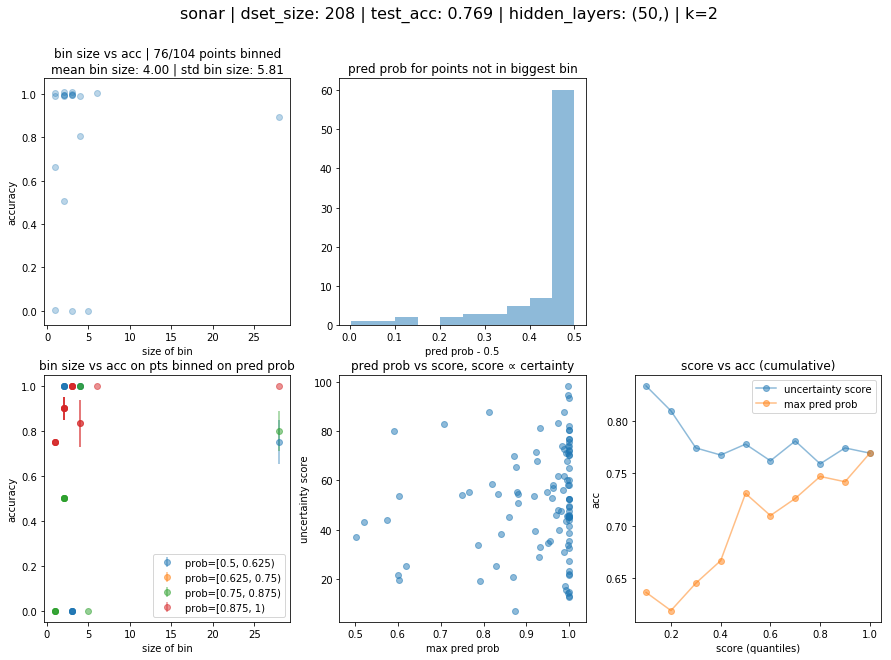

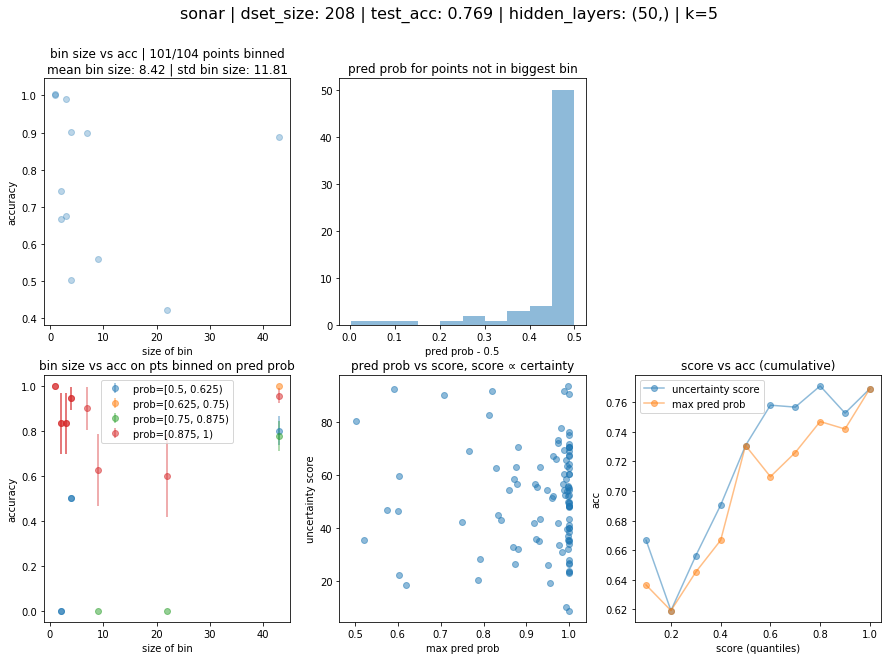

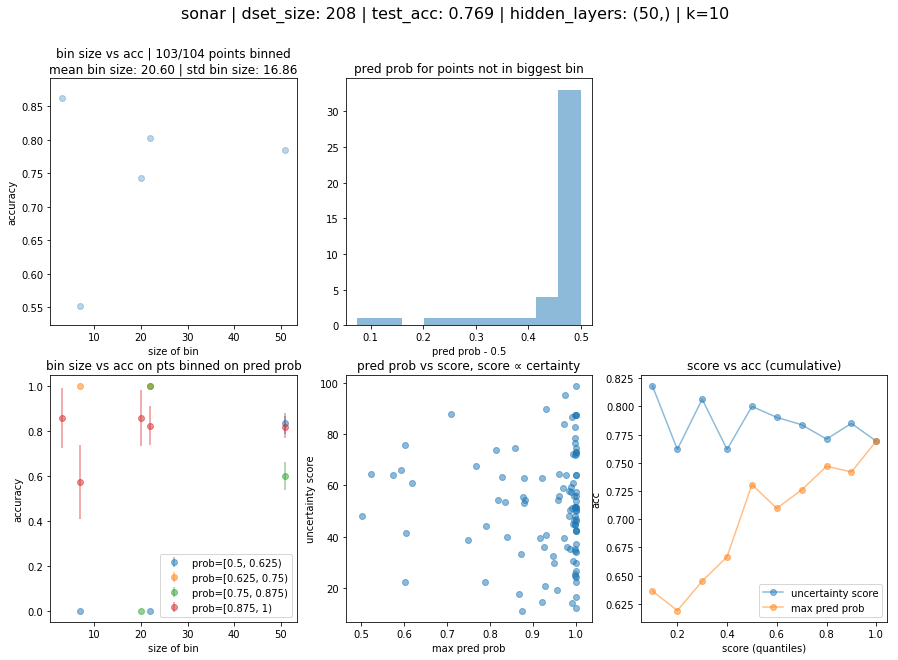

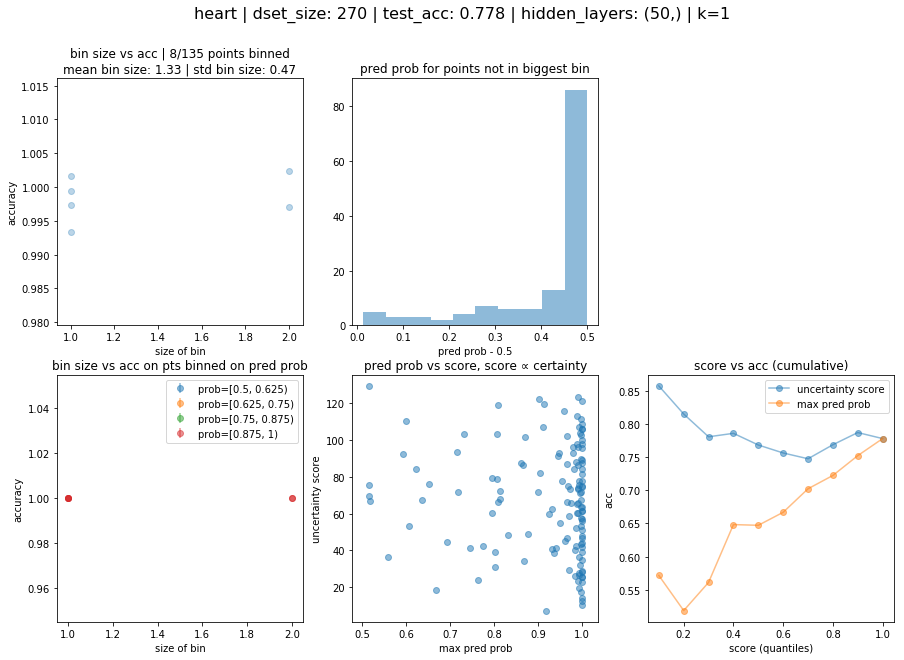

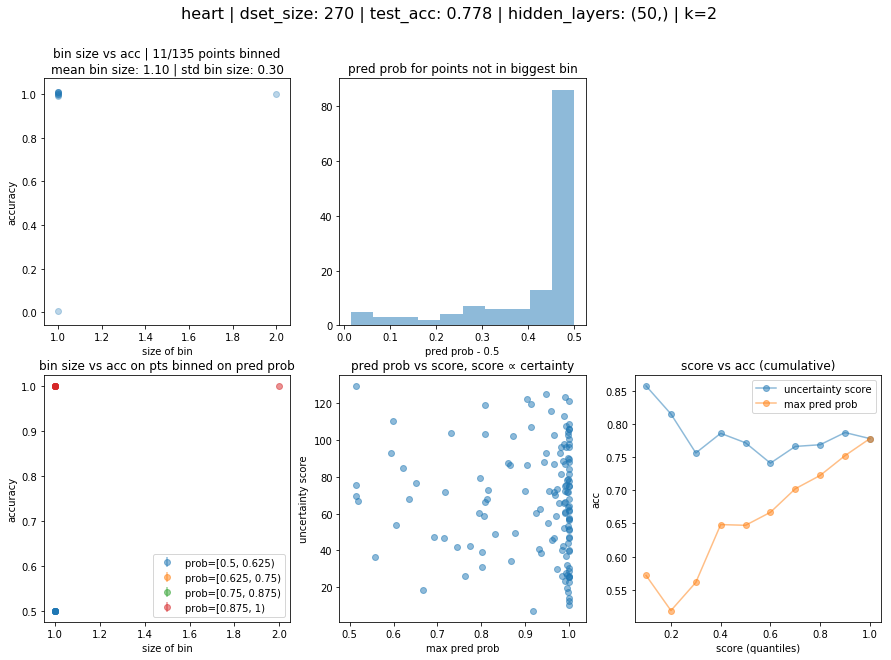

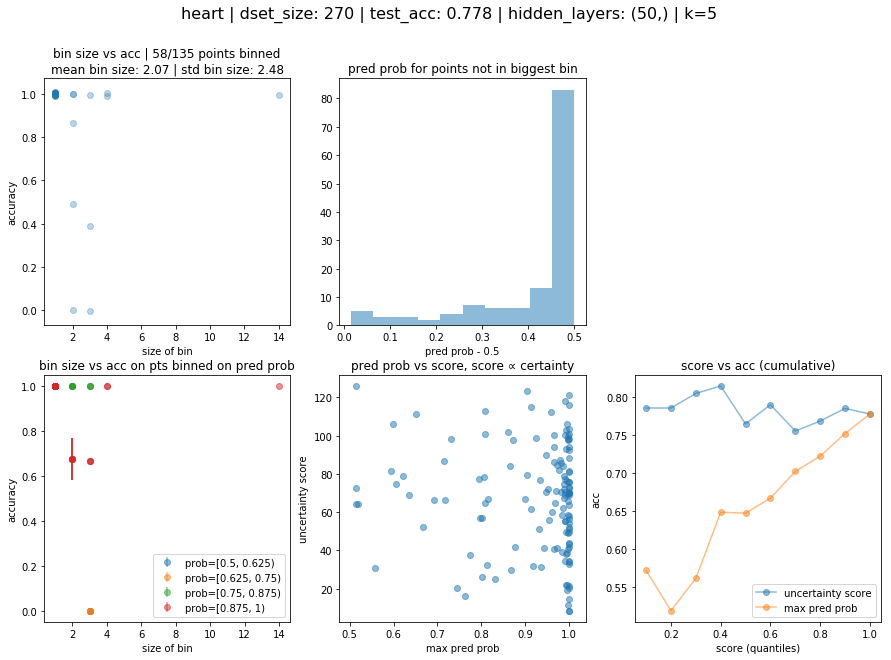

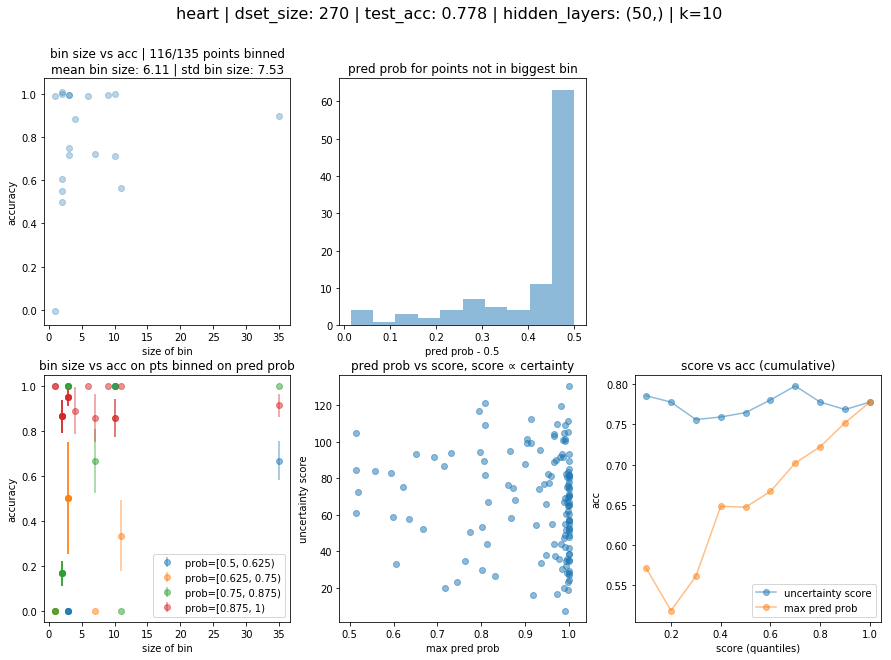

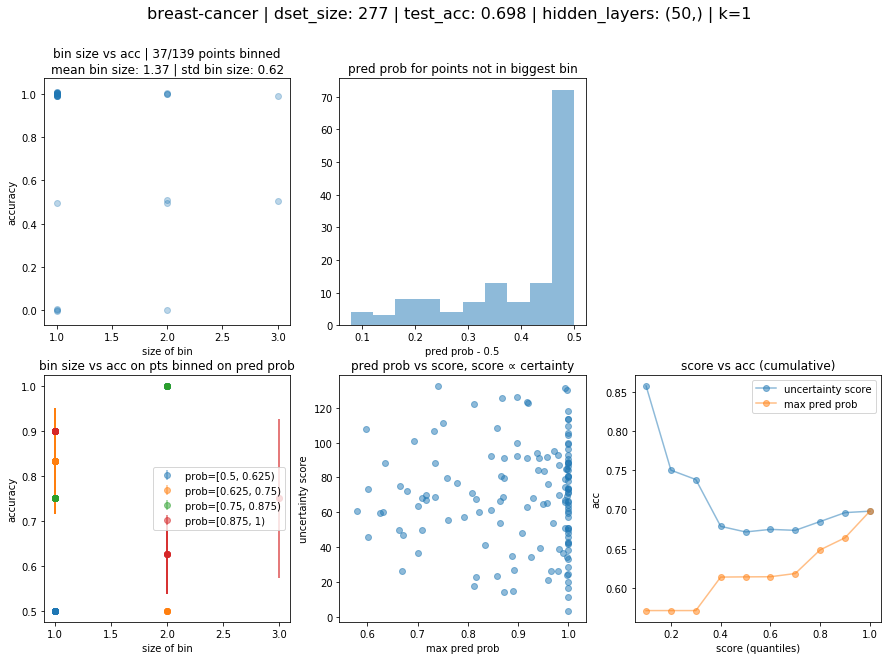

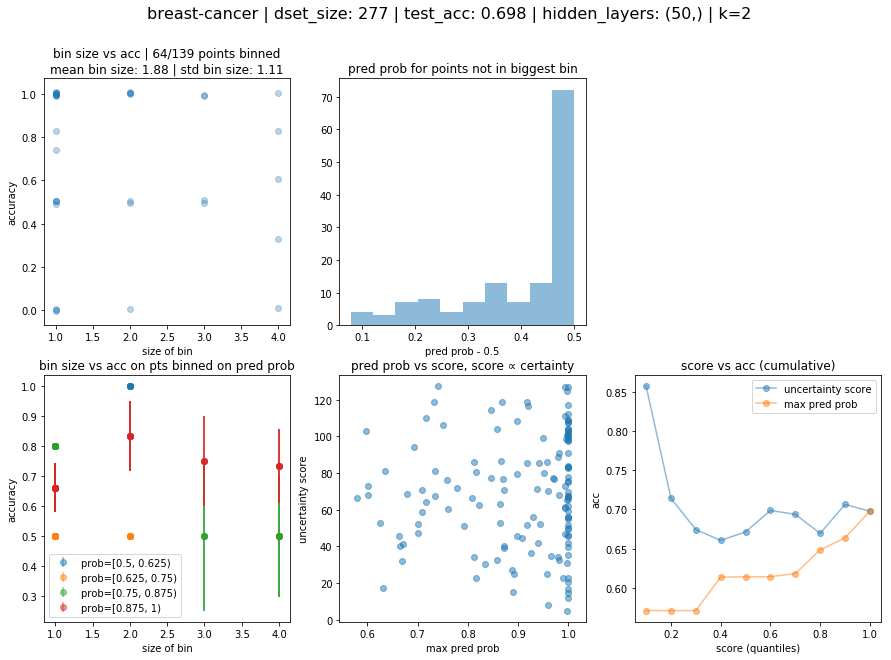

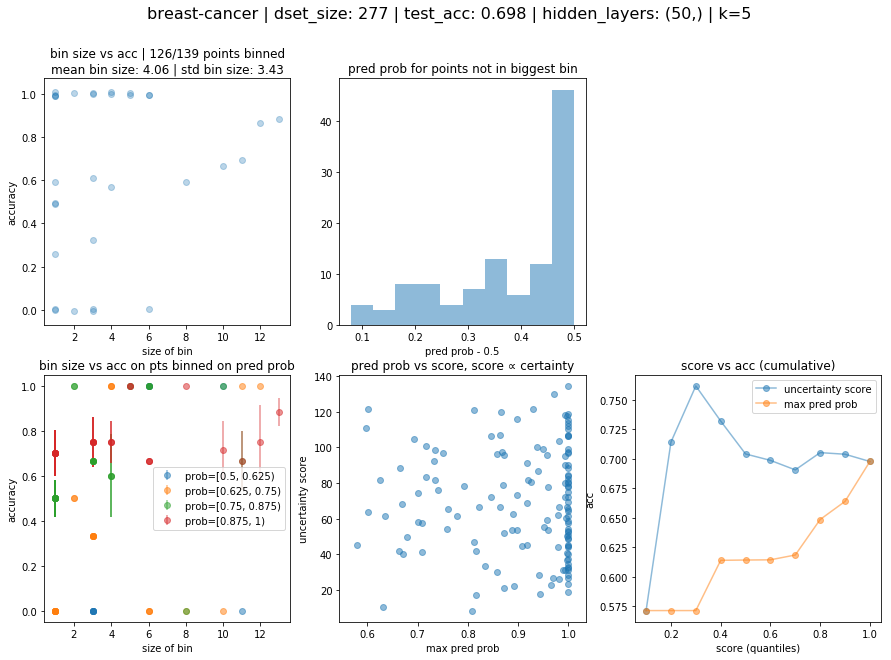

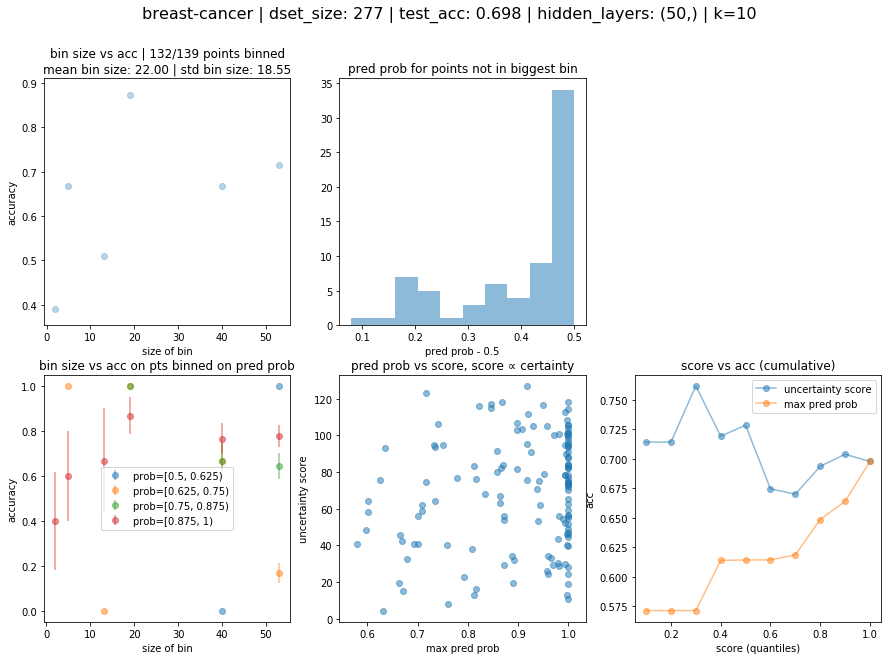

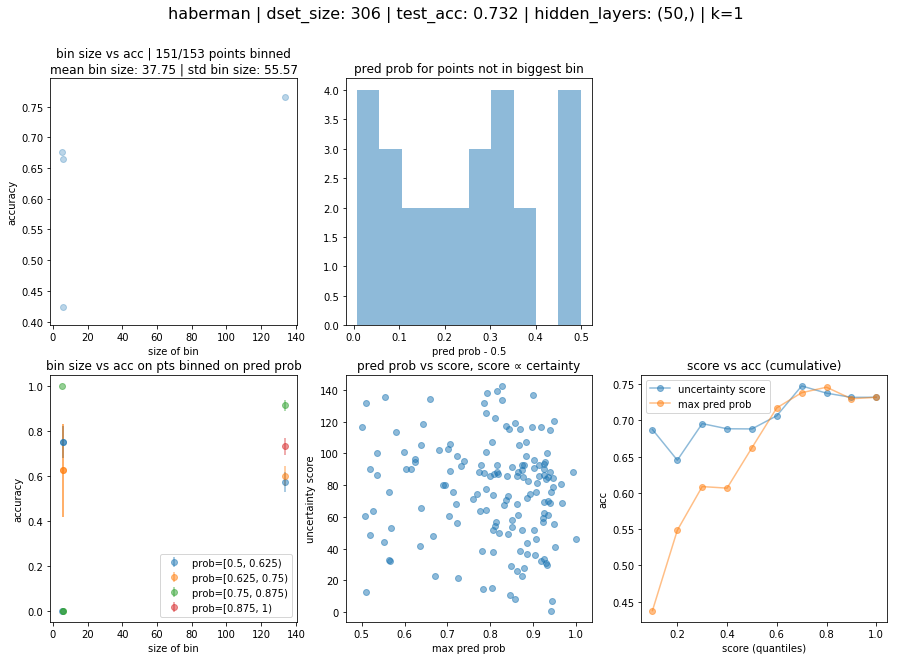

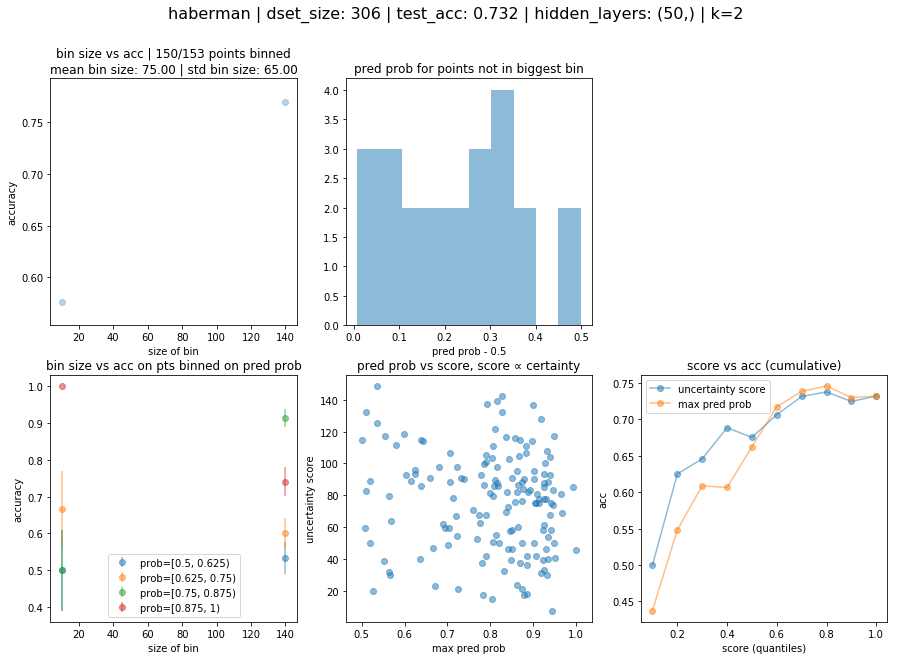

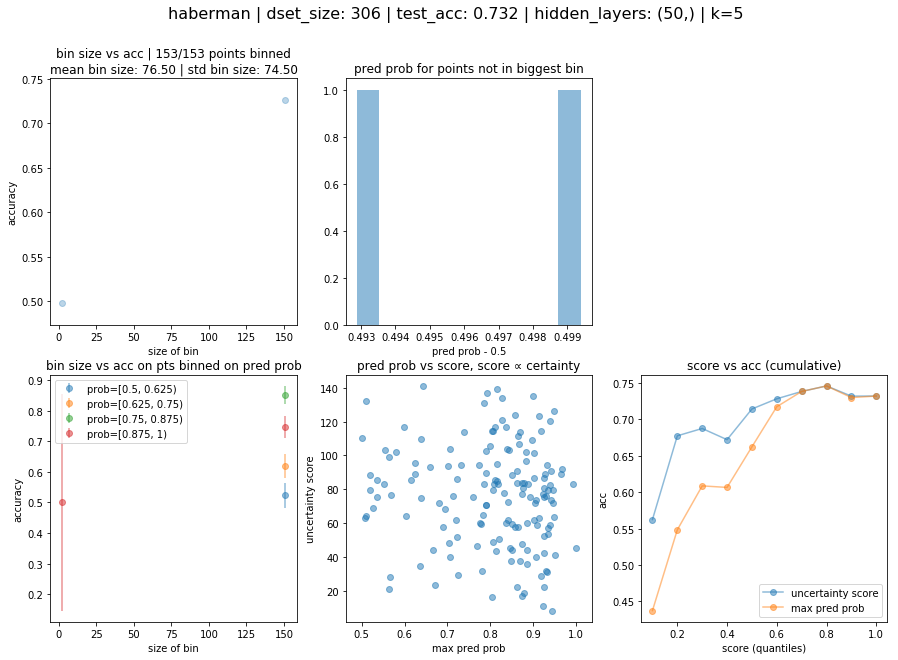

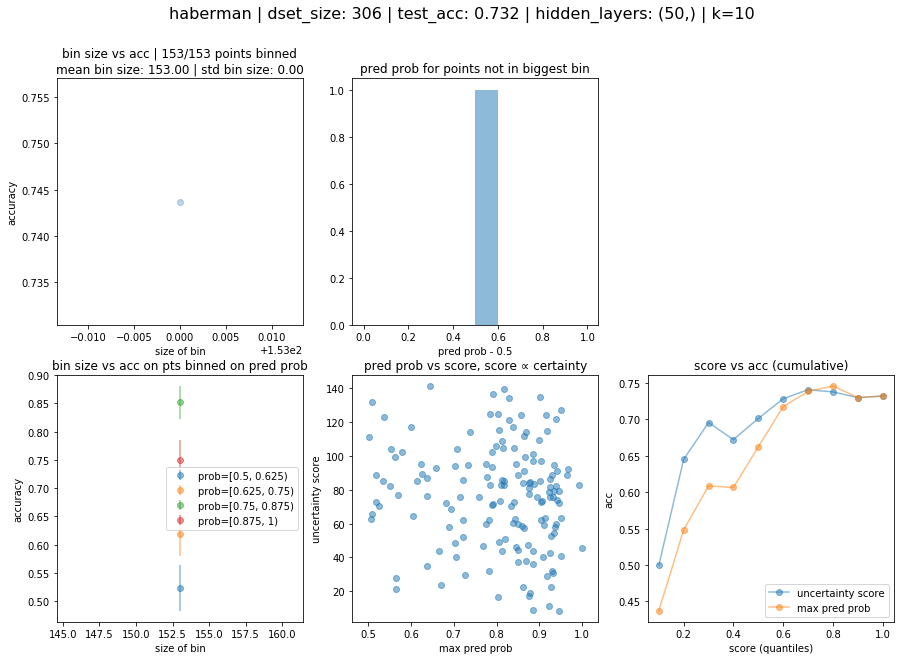

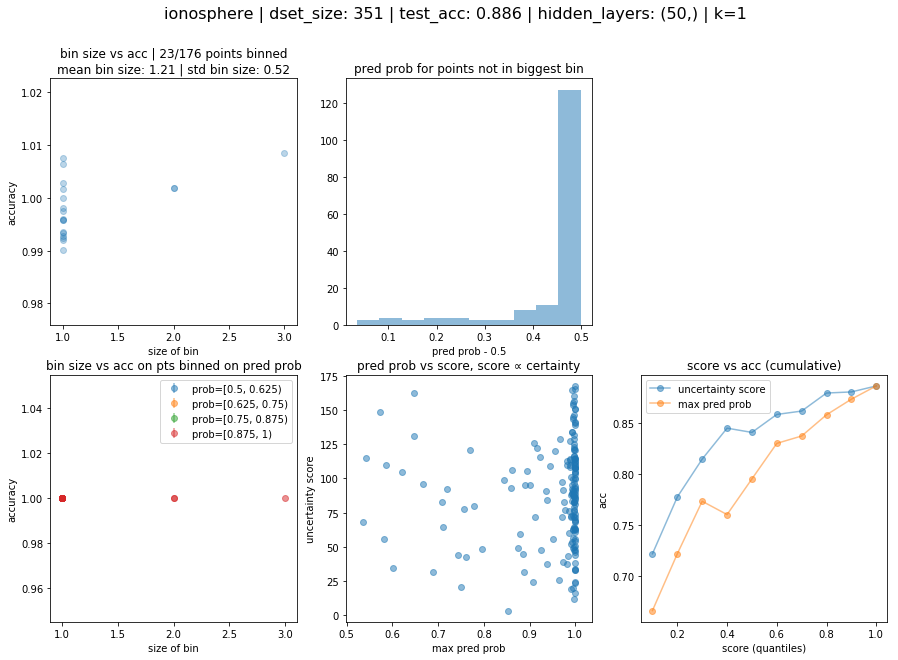

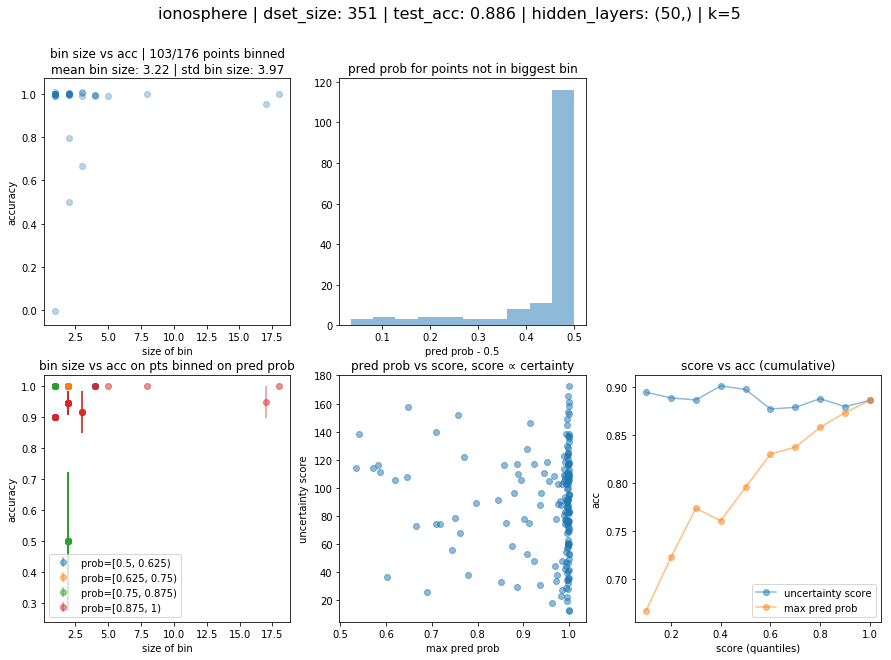

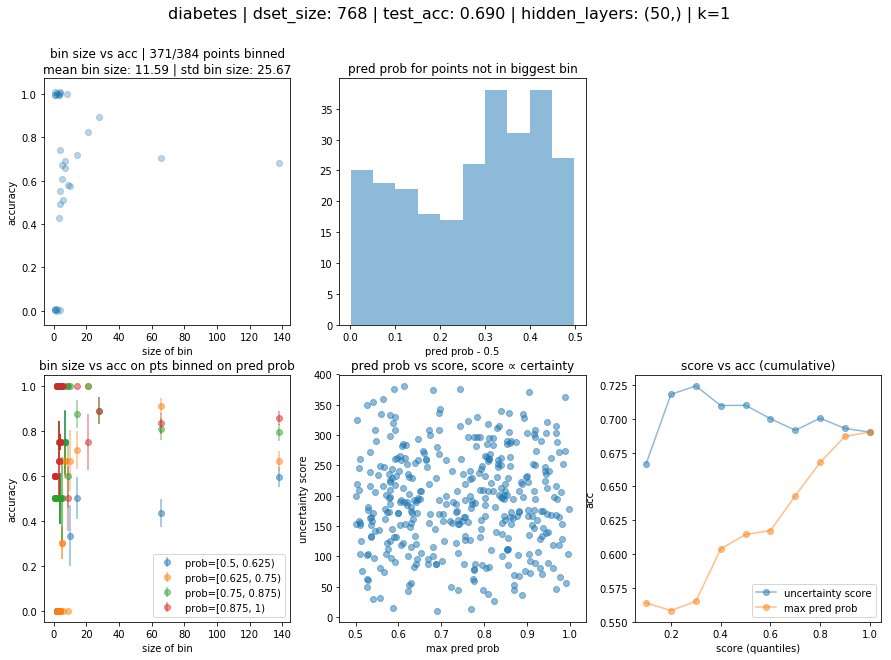

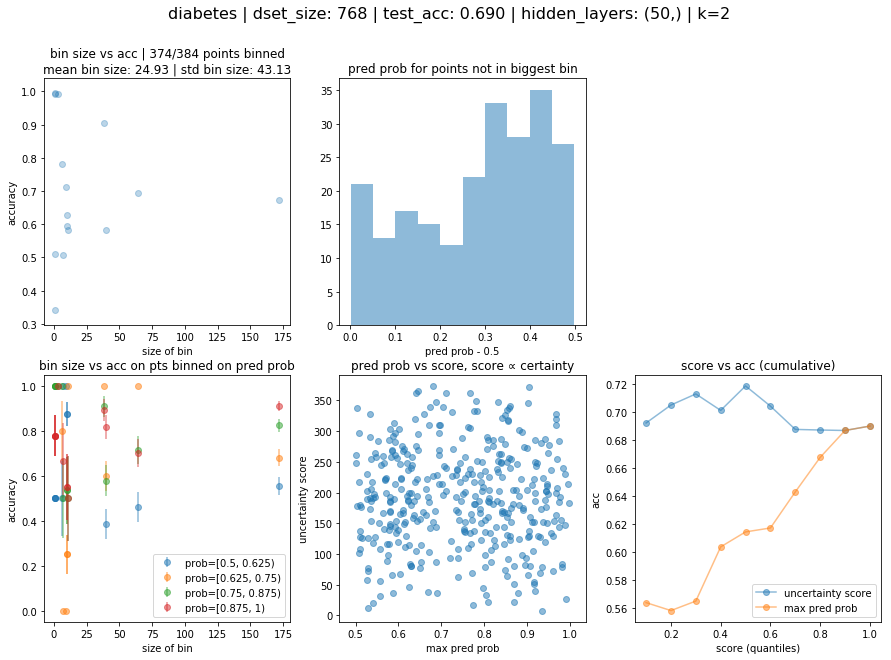

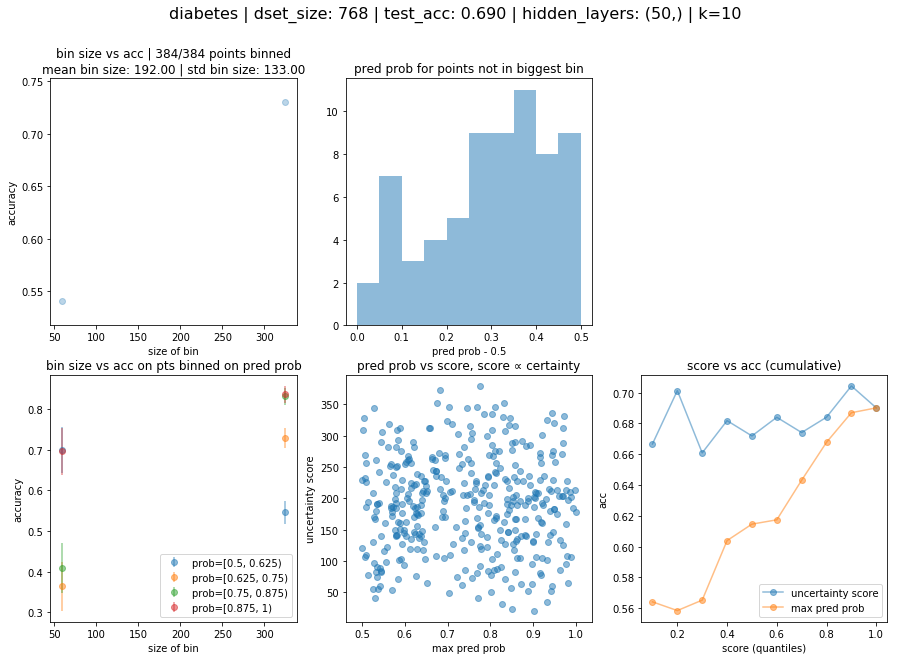

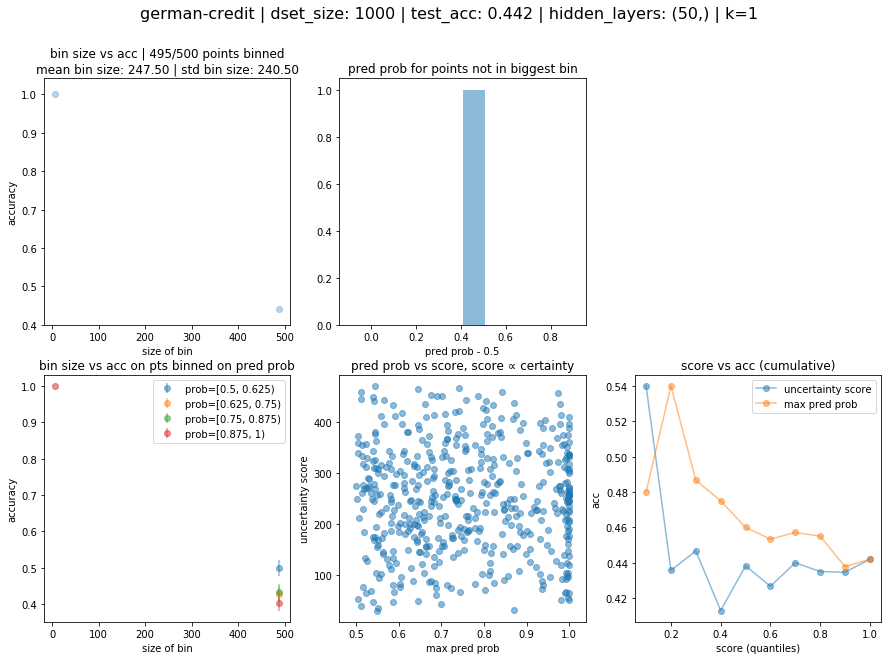

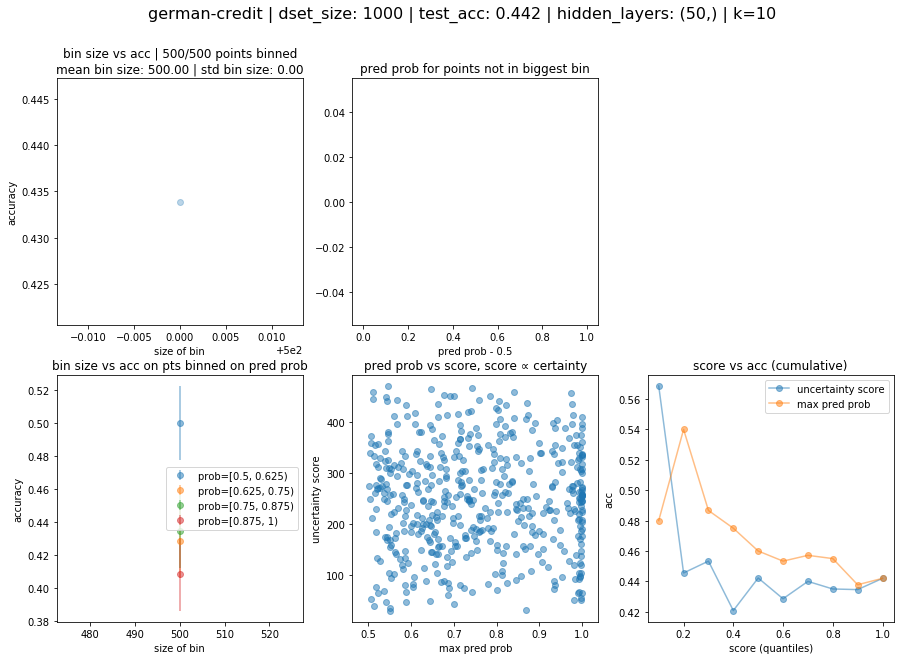

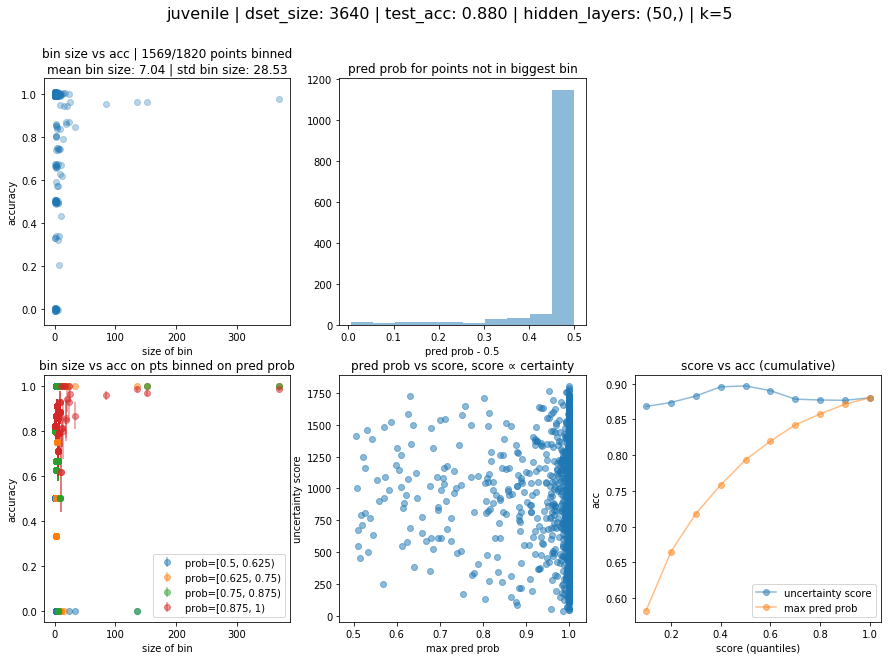

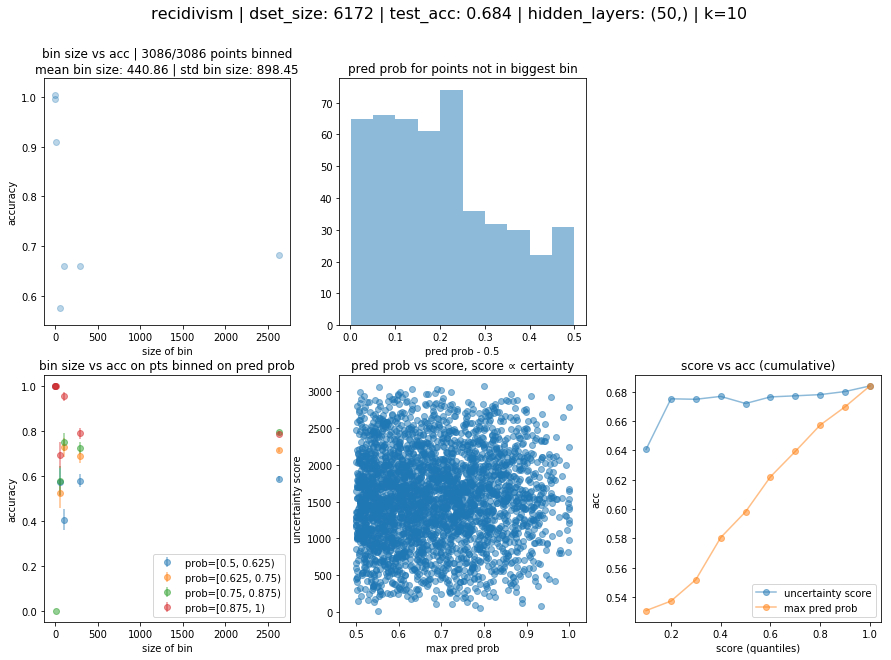

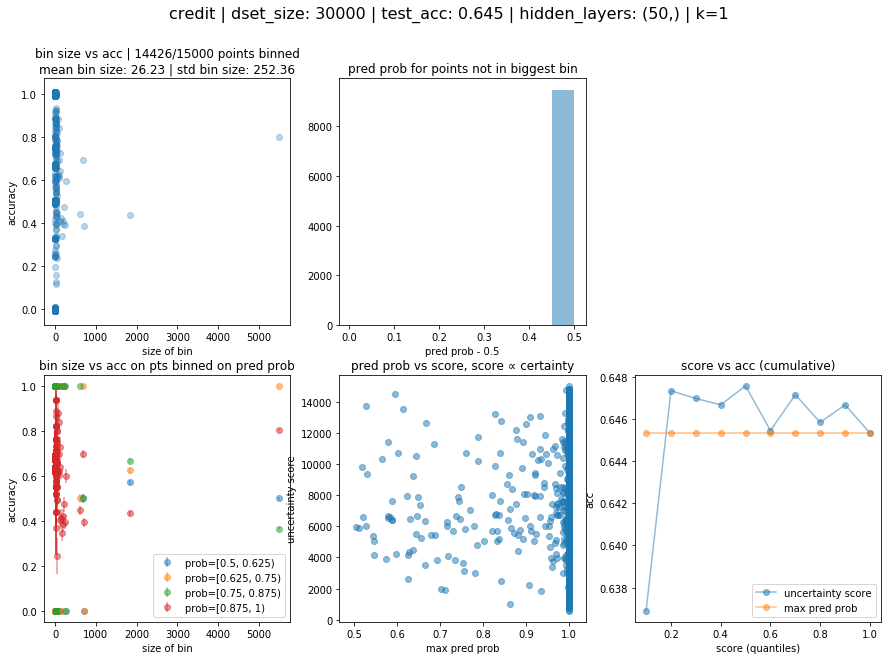

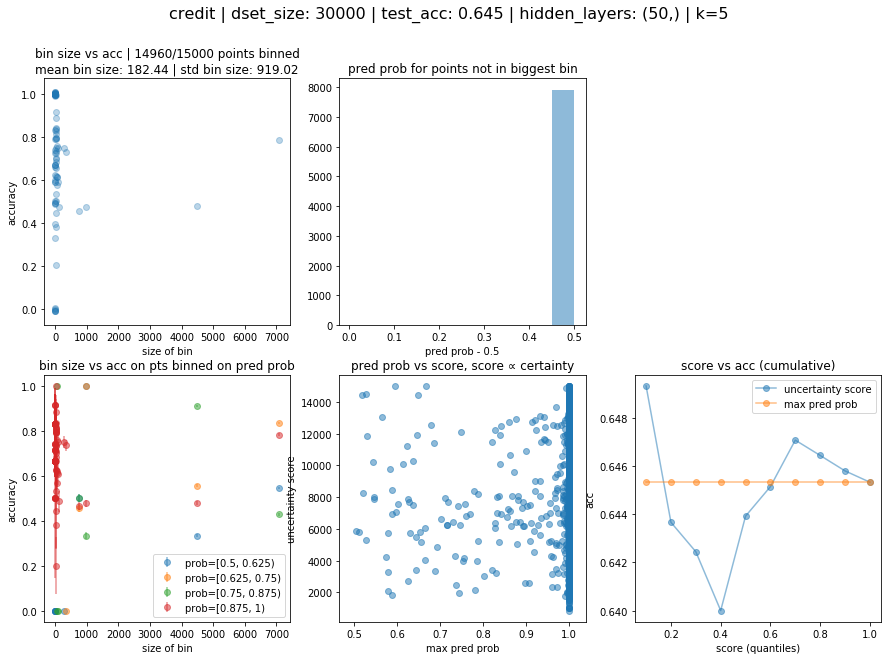

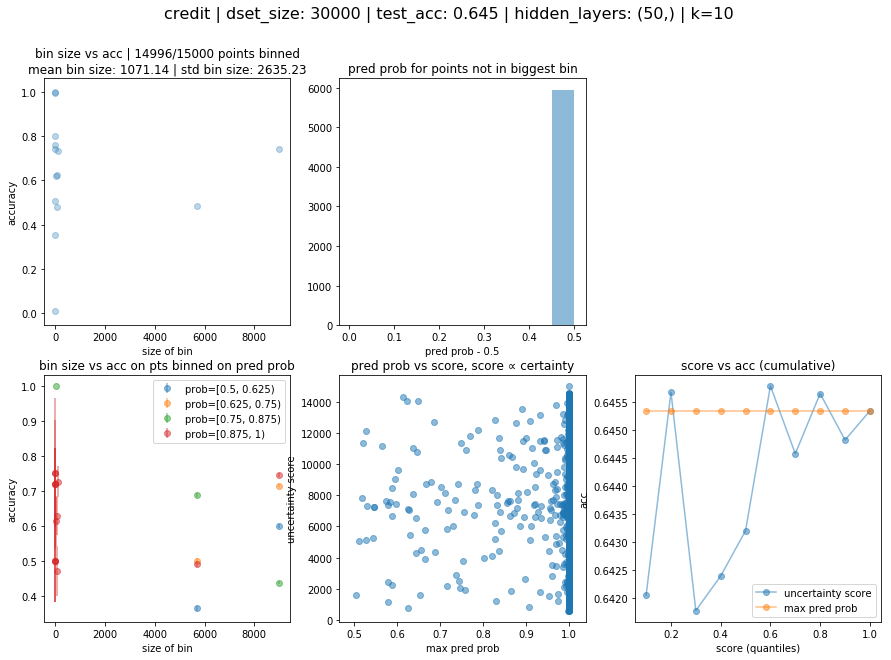

KeyboardInterrupt: 

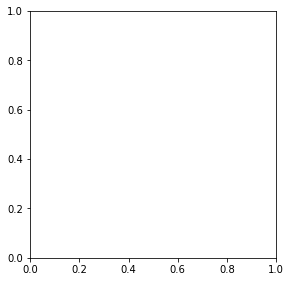

In [9]:
def activation_analysis(ds, name, num_neurons=50, num_hidden_layers=1, thresholds=[0.5, 0.625, 0.75, 0.875, 1], k=1):
    X, y = ds
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.5)
#     k = int(0.05 * num_neurons)
    hidden_layers = tuple(num_neurons for _ in range(num_hidden_layers))
    clf = MLPClassifier(hidden_layer_sizes=hidden_layers, max_iter=2000, random_state=1)
    clf.fit(X_train, y_train)
    
    bin_numbers = get_bin_numbers(clf, X_train, num_hidden_layers)
    test_bin_numbers = get_bin_numbers(clf, X_test, num_hidden_layers)
    correct_preds = clf.predict(X_test) == y_test
    
    f = plt.figure(figsize=(15, 10))
    ax1 = f.add_subplot(231)
    # find accuracy of each activation string bin
    bin_counts = Counter(bin_numbers)
    bin_sizes, acc, bin_map = [], [], []
    
    # create clusters from training points' corresponding embedding binary strings
    clusters = []
    for i, x, in enumerate(bin_numbers):
        added = False
        for cluster in clusters:
            if utils.hamming(x, cluster[0]) <= k:
                cluster.append(x)
                added = True
                break
        if not added:
            clusters.append([x])
    assert sum(len(cluster) for cluster in clusters) == len(bin_numbers)
    # assign each test bin num to a cluster
    seen_idxs = [False] * len(test_bin_numbers)
    for cluster in clusters:
        bin_num, bin_size = cluster[0], len(cluster)
        idxs = np.array([utils.hamming(test_bin_num, bin_num) <= k for test_bin_num in test_bin_numbers])
        idxs = np.array([seen_i == False and curr_i == True for curr_i, seen_i in zip(idxs, seen_idxs)])
        seen_idxs = np.logical_or(idxs, seen_idxs)  # record seen bin_nums
        if idxs.any():
            # find accuracy of points in bin
            acc.append(sum(correct_preds[idxs]) / len(correct_preds[idxs]))
            bin_sizes.append(bin_size)
            # bin pred prob of points in bin, bin those pred prods, and find acc of new bins
            bin_pred_probs = np.max(clf.predict_proba(X_test[idxs]), axis=1)
            percentiles, bin_acc = utils.get_binned_acc(bin_pred_probs, X_test[idxs], y_test[idxs], clf, thresholds=thresholds)
            error = np.sqrt(bin_acc * np.subtract(1, bin_acc) / sum(idxs)) 
            for i, perc in enumerate(percentiles):
                bin_map.append({'bin_size': bin_size, 'threshold': perc, 'acc': bin_acc[i], 'error': error[i]})
    assert sum(bin_sizes) <= len(test_bin_numbers), 'overcounting error'
    ax1.scatter(bin_sizes, acc + np.random.uniform(-0.01, 0.01, len(acc)), alpha=0.3)
    ax1.set_title(f"bin size vs acc | {sum(bin_sizes)}/{len(test_bin_numbers)} points binned\nmean bin size: {np.mean(bin_sizes):.2f} | std bin size: {np.std(bin_sizes):.2f}")
    ax1.set_xlabel('size of bin')
    ax1.set_ylabel('accuracy')
    
    
    ax3 = f.add_subplot(234)
    # plot bin size vs accuracy on points binned on pred prob
    for i, thresh in enumerate(thresholds[1:]):
        thresh_accs, thresh_bin_sizes, thresh_err = [], [], []
        for bin_size in bin_sizes:
            _acc = [x['acc'] for x in bin_map if x['bin_size'] == bin_size and x['threshold'] == thresh]
            _error = [x['error'] for x in bin_map if x['bin_size'] == bin_size and x['threshold'] == thresh]
            if _acc:
                thresh_accs.append(np.average(_acc))
                thresh_bin_sizes.append(bin_size)
                thresh_err.append(np.average(_error))
        ax3.errorbar(thresh_bin_sizes, thresh_accs, yerr=thresh_err, fmt="o", alpha=0.5, label=f"prob=[{thresholds[i]}, {thresholds[i+1]})")
    ax3.set_title(f"bin size vs acc on pts binned on pred prob")
    ax3.set_xlabel('size of bin')
    ax3.set_ylabel('accuracy')
    ax3.legend()
    
    ax2 = f.add_subplot(232)
    # find predicted probablity of points that are not in biggest bin
    dist = []
    biggest_bin = clusters[np.argmax([len(cluster) for cluster in clusters])][0]
    for i, x in enumerate(X_test):
        in_biggest_bin = utils.hamming(test_bin_numbers[i], biggest_bin) <= k
        if not in_biggest_bin:
            pred = max(clf.predict_proba([x]).flatten())
            dist.append(pred - 0.5)       
    utils.plot_hist(ax2, dist, None, 'pred prob for points not in biggest bin', alpha=0.5, xlabel='pred prob - 0.5')

    
    # uncertainty score vs pred prob: uncertainty score is where smallest bin size -> most uncertain, lowest pred prob -> most uncertain
    # current score = average(rank(bin_size), rank(pred_prob))
    ax4 = f.add_subplot(235)
    test_pred_probs = np.max(clf.predict_proba(X_test), axis=1)
    test_bin_size = bin_counts
#     test_bin_sizes = np.array([sum([bin_counts[bin_j] for bin_j in bin_counts if utils.hamming(bin_i, bin_j) <= k]) for bin_i in test_bin_numbers])
    test_bin_sizes = []
    for bin_i in test_bin_numbers:
        added = False
        for cluster in clusters:
            if utils.hamming(bin_i, cluster[0]) <= k:
                test_bin_sizes.append(len(cluster))
                added = True
                break
        if not added:
            test_bin_sizes.append(1)
    test_bin_sizes = np.array(test_bin_sizes)
    assert len(test_bin_sizes) == len(test_bin_numbers), 'should have same num of bin sizes as bin nums'
    scores = np.average([test_pred_probs.argsort(), test_bin_sizes.argsort()], axis=0)
    ax4.scatter(test_pred_probs, scores, alpha=0.5)
    ax4.set_title("pred prob vs score, score ∝ certainty")
    ax4.set_ylabel('uncertainty score')
    ax4.set_xlabel('max pred prob')

    
    ax5 = f.add_subplot(236)
    utils.plot_scores_vs_acc(ax5, clf, scores, X_test, y_test, 'uncertainty score', cumulative=True)
    utils.plot_scores_vs_acc(ax5, clf, test_pred_probs, X_test, y_test, 'max pred prob', cumulative=True)

    
    f.suptitle(f"{name} | dset_size: {len(X)} | test_acc: {clf.score(X_test, y_test):.3f} | hidden_layers: {hidden_layers} | k={k}", fontsize=16)
    plt.savefig(os.path.join(logdir, f"{name}-{num_neurons}N-{num_hidden_layers}HL-{k}K-embeddings"))
    plt.show()

for ds, name in zip(datasets, names):
#     if name != 'sonar':
#         continue
    thresholds = [0.5, 0.625, 0.75, 0.875, 1]
    # thresholds = [0.5, 0.75, 1]

#     activation_analysis(ds, name, 50, 1, thresholds, 2)
    activation_analysis(ds, name, 50, 1, thresholds, 1)
    activation_analysis(ds, name, 50, 1, thresholds, 2)
    activation_analysis(ds, name, 50, 1, thresholds, 5)
    activation_analysis(ds, name, 50, 1, thresholds, 10)


#     activation_analysis(ds, name, 20, 1, thresholds)
#     activation_analysis(ds, name, 30, 1, thresholds)
#     activation_analysis(ds, name, 50, 1, thresholds, 0)
#     activation_analysis(ds, name, 100, 1, thresholds)
#     activation_analysis(ds, name, 200, 1)
#     activation_analysis(ds, name, 500, 1)
#     activation_analysis(ds, name, 1000, 1)

    
#     activation_analysis(ds, name, 50, 2)